# A CNN model for predicting cleavage and polyadenylation sites

This CNN model is based on [fastai v2](https://github.com/fastai/fastai2), a deep learning library based on PyTorch.  

During the first few hours of working on this project, the model either had bugs or was as stupid as a coin (with a constant 63% accuracy). After I reduced the width of the input sequences (thus avoiding background and focusing on the signal), the accuracy suddenly improved to 81%. After trying different architectures, the accuracy has reached 94.0% and the AUC is 0.98.

In [1]:
from fastai2.data.all import *
from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.vision.all import *

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, precision_recall_curve

import pandas as pd
import matplotlib.pyplot as plt


## Define functions for extracting genomic DNA sequence

In [2]:
def load_genome(genome_dir):
    '''Read fasta files containing genomic sequence from genome_dir into a dict.'''
    fasta_files = Path(genome_dir).glob('chr*.fa')
    genome = {}
    for fasta_file in fasta_files:
        with open(fasta_file, 'r') as f:
            f.readline()
            line = f.read()
            genome[str(fasta_file.name).replace('.fa', '')] = line.replace('\n', '')
    return genome
    
       
def reverse_complement(seq, mol_type = 'DNA'):
    '''Get reverse complement of seq.'''
    # Genomic sequences contain both lower and upper case letters   
    seq = seq.upper()
    if mol_type == 'DNA':
        complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A', 'N': 'N'}
    elif mol_type == 'RNA':
        complement = {'A': 'U', 'C': 'G', 'G': 'C', 'U': 'A', 'N': 'N'}
    return "".join(complement.get(base) for base in reversed(seq))
    

def get_seq(chromosome, strand, position, offset, genome):
    '''Get stranded genomic sequence (-80nt ~ 40nt) from the cleavage site (position).'''
    if strand == '+': 
        start = position + offset - 80
        end   = position + offset + 40
        seq   = genome[chromosome][(start-1) : end].upper() 
    elif strand == '-': 
        start = position + offset - 40
        end   = position + offset + 80
        seq   = genome[chromosome][(start-1) : end].upper() 
        seq   = reverse_complement(seq, mol_type = 'DNA')
    return seq

## Get sequences surrounding polyadenylation (pA ) sites

In [3]:
# Directory containing fasta files for different genomes
GENOME_FASTA_DIR = '/home/dinghai/projects/fud/ucsc/genomes' 

GENOME = 'mm9' 

genome_dir = Path(GENOME_FASTA_DIR)/GENOME

Reand the file containing pA site information, which is the output from [**Part 1 of my 3'READS+ pipeline**](https://github.com/DinghaiZ/3-prime-READS-plus/blob/master/projects/project_1/experiment_1/notebooks/Part-1.ipynb). Only the first three columns are needed for extracting sequences. The other columns are used to to filter lowly expressed pA sites.

In [4]:
pA_cluster_file = '/home/dinghai/projects/ER/191105_C2C12_Puromycin/results/clusters.using.all.reads.csv'

pA_clusters = pd.read_csv(pA_cluster_file)

pA_clusters.head()

,chromosome,strand,position,Ctrl_Cyto_1,Ctrl_Cyto_2,Ctrl_ER_1,Ctrl_ER_2,Puro_Cyto_1,Puro_ER_1,Puro_Cyto_2,Puro_ER_2
0,chr12,-,3121202,0,0,0,1,0,0,0,0
1,chr12,-,3160002,0,1,0,0,0,0,0,0
2,chr12,-,3232818,0,0,0,1,1,1,0,0
3,chr12,-,3232888,1,0,0,0,0,0,0,0
4,chr12,-,3233135,0,3,0,2,0,0,0,0


In [5]:
pA_clusters.shape

(326517, 11)

Filter out pA sites in chromosome M, because most of them are not real.

In [6]:
pA_clusters = pA_clusters[pA_clusters.chromosome != 'chrM']

pA_clusters.shape

(325800, 11)

Filter out pA sites supported with low read #, because they tend to be noise too.

In [7]:
pA_clusters = pA_clusters[pA_clusters.filter(regex='_\d$', axis=1).sum(axis=1) >= 8*5]

pA_clusters.shape

(27813, 11)

In [8]:
pA_clusters.head()

,chromosome,strand,position,Ctrl_Cyto_1,Ctrl_Cyto_2,Ctrl_ER_1,Ctrl_ER_2,Puro_Cyto_1,Puro_ER_1,Puro_Cyto_2,Puro_ER_2
8,chr12,-,3247430,57,65,65,64,59,52,52,71
10,chr12,-,3247714,7,15,19,53,15,20,13,26
27,chr12,-,3249475,5,6,9,15,11,7,5,12
30,chr12,-,3249704,140,129,145,219,210,146,179,161
63,chr12,-,3631620,0,0,5,6,2,10,3,15


Extract genomic sequences surrounding the pA sites.

In [9]:
genome = load_genome(genome_dir)

In [10]:
positive_seqs = pA_clusters.apply(lambda row: 
                                  get_seq(row.chromosome, row.strand, row.position, 
                                          offset=0, genome=genome), 
                                  axis=1) 

In [11]:
positive_seqs.head()

8     ATACTCTACTTAACAATTTAAATAAACTGAAATATTTCTAGATGGTCTACTTCTGTTCATATAAAAACAAACCTGATTTCCAACTGTGTGGTTTGGTTTTCATTTATTTTTGGAGTTGGAG
10    TAATTATAATCGACATTGTACAGAGAAAGGATAAGGCTACCTTTGTTAAATCTGCACTTTCTGAATATCAAAAAAAAAAACAAAAAAAACAAAAAAACCCACCAAAAGGGAAATGGAAGTA
27    GATTTACTTGCTCACTCAGCCCTGCACTTCAGTTGTATTATAGTCCAGTTCTTATCAACATTAAACTAGAGCAATCATTTCAACTATTCTGCAAATTGTATAAGAATAAAAGTTAGAATTA
30    GCTCTCCTGTCCATCTGCTGCCATCCACCATCCGGTTCTCTTCTTGCTGCAAAATAAAACACTCTGTCCATTTTTAACTCTAAACAGATATTTTTGTTTCTCATCTTAACTATTCAATCCA
63    CGTAAGGAGATCTGAATCCCTCTTCTGGAGTGTCTGAAGACAGCTGCCGTGTACTTACATATAATAAATAAATACATCTTTTTTTTTTTTAAATCTACTTTTAAACTAGAAAACCAAAAAT
dtype: object

## Get background sequences as negative examples
I'll use sequences 200nt upstream or downstream of the pA sites as negative examples. Since these sequences are close to the pA sites, they tend be similar to the positive examples in terms of base composition. If we use CDS sequences or intergenic sequences, it might be too easy for the model to tell the difference.

But first of all, we need to avoid sequences that overlaps with other pA sites, since the distance between two pA sites could be around 200nt. 

In [12]:
pA_clusters = pA_clusters.sort_values(by=['chromosome', 'position'])

In [13]:
previous_pAs = (pA_clusters
                .position[:-1]
                .reset_index()
                .rename(columns={'index': 'previous_index', 'position':'previous_position'})
               )

next_pAs      = (pA_clusters
                .position[1:]
                .reset_index()
                .rename(columns={'index': 'next_index', 'position':'next_position'})
               )

aligned_pAs = pd.concat([previous_pAs, next_pAs], axis=1)

aligned_pAs['distance'] = aligned_pAs['next_position'] - aligned_pAs['previous_position'] 

In the cell below, 280 = 200 + 80 and 120 = 200 - 80.

In [14]:
close_pAs = aligned_pAs[((aligned_pAs['distance'].abs()<280) & (aligned_pAs['distance'].abs()>120)) 
                        & (aligned_pAs['next_index']-aligned_pAs['previous_index']<10)]

close_pA_index = set(close_pAs['previous_index']).union(close_pAs['next_index'])

In [15]:
pA_clusters = pA_clusters.loc[[i for i in pA_clusters.index.values if not i in close_pA_index]]
pA_clusters

,chromosome,strand,position,Ctrl_Cyto_1,Ctrl_Cyto_2,Ctrl_ER_1,Ctrl_ER_2,Puro_Cyto_1,Puro_ER_1,Puro_Cyto_2,Puro_ER_2
15593,chr1,-,4764020,6,10,7,5,6,1,10,6
15596,chr1,-,4766465,2182,2278,1063,2147,2651,1265,2019,1697
44092,chr1,+,4835279,12,9,6,6,15,4,8,1
44096,chr1,+,4836815,242,174,120,176,262,95,142,122
15608,chr1,-,4847354,0,3,2,15,2,9,3,6
...,...,...,...,...,...,...,...,...,...,...,...
141967,chrX,-,166414227,2,0,9,7,1,6,5,15
31894,chrX,+,166428727,36,10,51,17,18,44,16,33
326027,chrX_random,-,10851,14,14,12,11,10,10,10,9
326321,chrX_random,+,334185,108,53,164,181,169,93,129,93


In [16]:
downstream_seqs = pA_clusters.apply(lambda row: 
                                    get_seq(row.chromosome, row.strand, row.position, 
                                            offset=200, genome=genome), 
                                    axis=1) 

upstream_seqs   = pA_clusters.apply(lambda row: 
                                    get_seq(row.chromosome, row.strand, row.position, 
                                            offset=-200, genome=genome), 
                                    axis=1) 

negative_seqs   = pd.concat([upstream_seqs, downstream_seqs])

In [17]:
positive_seqs = positive_seqs.to_frame(name='seq')
positive_seqs['label'] = 'pA'
positive_seqs.head()

,seq,label
8,ATACTCTACTTAACAATTTAAATAAACTGAAATATTTCTAGATGGTCTACTTCTGTTCATATAAAAACAAACCTGATTTCCAACTGTGTGGTTTGGTTTTCATTTATTTTTGGAGTTGGAG,pA
10,TAATTATAATCGACATTGTACAGAGAAAGGATAAGGCTACCTTTGTTAAATCTGCACTTTCTGAATATCAAAAAAAAAAACAAAAAAAACAAAAAAACCCACCAAAAGGGAAATGGAAGTA,pA
27,GATTTACTTGCTCACTCAGCCCTGCACTTCAGTTGTATTATAGTCCAGTTCTTATCAACATTAAACTAGAGCAATCATTTCAACTATTCTGCAAATTGTATAAGAATAAAAGTTAGAATTA,pA
30,GCTCTCCTGTCCATCTGCTGCCATCCACCATCCGGTTCTCTTCTTGCTGCAAAATAAAACACTCTGTCCATTTTTAACTCTAAACAGATATTTTTGTTTCTCATCTTAACTATTCAATCCA,pA
63,CGTAAGGAGATCTGAATCCCTCTTCTGGAGTGTCTGAAGACAGCTGCCGTGTACTTACATATAATAAATAAATACATCTTTTTTTTTTTTAAATCTACTTTTAAACTAGAAAACCAAAAAT,pA


In [18]:
negative_seqs = negative_seqs.to_frame(name='seq')
negative_seqs['label'] = 'Non-pA'
negative_seqs.head()

,seq,label
15593,AGGATAAGAACTCAAACAGGGCAGCAGCTCATGTAGAGACCATGGAGCATGCTGCTTACTGACTTGCTCCTCATGGCTTGCTCAGCCTGCTTCCTTATAAAACCCGAGATCACCAGCCCAC,Non-pA
15596,TTTAGAAAGGGGATTAAAAAGAAAAAAACCTACTTAAAATTACCTTTCTTTTGGGGGGTGGGGAGACTGTGTTTTGATACATGGTTTCTCTGTGTAGCCCTGGCTGTCCTGGAACTTGTTC,Non-pA
44092,TTTCTGACTTCTGTAGCTGTTTATTAAATCATTTTTTCCAAACAGGAAATGATGGATGTCAAGCACTTCATTGATAAGCTCCTACCTCCAATTGATTGACATCACTAAGAGGCCTTGAGTA,Non-pA
44096,AACCAACCAAGAAGCACCTTTATAAACAGGTGCTAATTGATATGAAGATCATTTTGGTATGTCCTAGATAGAATGAAGCCAAATGTCTGGATTTAAAACAATTTCAAACAATCATTTACTA,Non-pA
15608,ACTAATGTGCATTTTCACACTTTAAACTTAAGATCAAATAAAGTATAGCTCCCCAGGGTAACAGTGAATTCCACTTTGACTAATCAGTTTCTATTGAAAGTAAATGGTTCAGTACCATTTT,Non-pA


In [19]:
seqs = pd.concat([positive_seqs, negative_seqs], axis=0)
seqs.shape

(74433, 2)

In [20]:
seqs = seqs[~seqs['seq'].str.contains(r'N')]
seqs.shape

(74432, 2)

## Define "Transformations" for turning sequences into arrays 

In [21]:
@Transform
def extract_from_df(df, col_name): return str(df[col_name])

The Transform class usally have 'encodes' and 'decodes' methods for doing the forward and reverse transformation.

In [23]:
class Seq2Array(Transform):
    "Convert sequence of 'mol_type' into a numpy array"
    order=10
    def __init__(self, mol_type = 'DNA'):
        self.b2v = {'A':[1., 0, 0, 0],
                    'T':[0, 1., 0, 0],
                    'C':[0, 0, 1., 0],
                    'G':[0, 0, 0, 1.]
                    }
        self.vocab = ['A', 'T', 'C', 'G']
        if mol_type == 'RNA':
            del self.b2v['T']
            self.b2v['U'] = [0, 1., 0, 0]
            self.vocab = ['A', 'U', 'C', 'G']
     
    def encodes(self, seq:str): return array([self.b2v[b] for b in seq]).T[None]
    def decodes(self, arr):  
        base_arr = array(self.vocab*arr.shape[2]).reshape(-1, 4)
        return ''.join(base_arr[arr[0].T==1])

Do some testing:

In [24]:
s2a = Seq2Array(mol_type='RNA')
a = s2a('AAUCGGCUU')
test_eq(a.shape, (1, 4, 9))
a

array([[[1., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 1., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 1., 0., 0., 0.]]])

In [26]:
test_eq(s2a.decodes(a), 'AAUCGGCUU')

## Create a DataSource using Transformations and a Splitter.
'tfms[0]' will be applied to the independent variable (seq) and 'tfms[1]' will be applied to the dependent variable (label). RandomSplitter() will randomly split the data into a training set (80%) and a test set (20%).

In [27]:
tfms = [[partial(extract_from_df, col_name='seq')],
        [partial(extract_from_df, col_name='label'), Categorize(), OneHotEncode()]]

split_idx = RandomSplitter()(seqs)

dsrc = DataSource(seqs, tfms, splits=split_idx)

In [28]:
dsrc.train[0]

('GTATCTTTCTCTCCCTTCACTGGGATGGTTTCTGTAACGACCTGTAAGTGCTGTTTCTGAGATGGAGCCGCCTCATCTTTACCATCGAACCTCCTTTTCTTTCTAGGTTAAGCAGCTGCCC',
 tensor([1., 0.]))

## Create a DataBunch and move the data to GPU

In [30]:
torch.cuda.is_available()

True

More transforms will be applied to the data:

In [31]:
dbch = dsrc.databunch(bs=64, 
            after_item  = [Seq2Array(mol_type='DNA'), ToTensor()], 
            after_batch = [Cuda(), IntToFloatTensor()])

Have a look at one batch of transformed data:

In [32]:
dbch.one_batch()

(tensor([[[[0., 0., 0.,  ..., 0., 0., 1.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [1., 1., 0.,  ..., 0., 1., 0.],
           [0., 0., 1.,  ..., 1., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 1., 0.,  ..., 0., 1., 0.],
           [0., 0., 0.,  ..., 1., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 1.],
           [1., 0., 1.,  ..., 0., 0., 0.]]],
 
 
         ...,
 
 
         [[[0., 1., 0.,  ..., 0., 0., 0.],
           [0., 0., 1.,  ..., 1., 0., 1.],
           [1., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 1., 0.]]],
 
 
         [[[0., 1., 0.,  ..., 0., 0., 0.],
           [1., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 1.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 1., 1., 1.]]],
 
 
         [[[0., 1., 1.,  ..., 0., 0., 0.],
           [1., 0., 0.,  ..., 1., 0., 1.],
      

## Define a CNN Model

In [34]:
drop_p = 0.1
m = nn.Sequential(
                  nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(4,6), stride=1),
                  nn.BatchNorm2d(16),
                  nn.ReLU(),
                  nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(1,6), stride=2),
                  nn.BatchNorm2d(32),
                  nn.ReLU(),
                  nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1,6), stride=2),
                  nn.BatchNorm2d(32),
                  nn.ReLU(),
                  AdaptiveConcatPool2d(size=(1,6)),
                  Flatten(),
#                   nn.Dropout(drop_p), # Dropout did not help much for this model 
                  nn.Linear(in_features=384, out_features=2),
                 ).double().cuda()

I have to overwrite the `accuracy` function from fastai:

In [35]:
def accuracy(inp, targ, axis=-1):
    "Compute accuracy with `targ` when `pred` is bs * n_classes"
    pred,targ = flatten_check(inp.argmax(dim=axis), targ.argmax(dim=axis))
    return (pred == targ).float().mean()

Create a `Learner` consisted of data, model, metrics, loss function, and optimizer:

In [36]:
learn = Learner(dbch, m, metrics=accuracy,
                loss_func=BCEWithLogitsLossFlat(),
                opt_func=partial(Adam, wd=0.01, eps=1e-3)
               )

In [37]:
print(learn.summary())

Sequential (Input shape: 64 x 1 x 4 x 121)
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 16 x 1 x 116    400        True      
________________________________________________________________
BatchNorm2d          64 x 16 x 1 x 116    32         True      
________________________________________________________________
ReLU                 64 x 16 x 1 x 116    0          False     
________________________________________________________________
Conv2d               64 x 32 x 1 x 56     3,104      True      
________________________________________________________________
BatchNorm2d          64 x 32 x 1 x 56     64         True      
________________________________________________________________
ReLU                 64 x 32 x 1 x 56     0          False     
________________________________________________________________
Conv2d               64 x 32 x 1 x 26     6,176      True      
_______________________________________________________

Fit one epoch using the default maximum learning rate of 1e-3:

In [38]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.201177,0.195989,0.929800,00:22


Plot scheduled learning rate (left) and momentum (right):

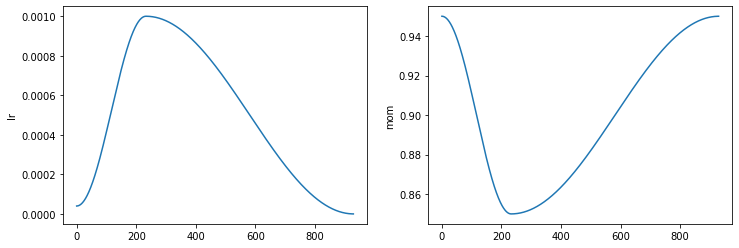

In [39]:
learn.recorder.plot_sched()

Find optimum learning rate (Personally I don't think the lr_find method is helpful this time.):

In [42]:
# learn.lr_find(end_lr=0.1) 

The above plot suggests that we can use 1e-4 as the maximum learning rate.

In [41]:
learn.fit_one_cycle(10, lr_max=1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.187748,0.193622,0.931882,00:21
1,0.175895,0.187327,0.933226,00:22
2,0.174112,0.181609,0.935308,00:21
3,0.160595,0.179246,0.934838,00:21
4,0.168756,0.175533,0.936249,00:21
5,0.151519,0.174252,0.936921,00:21
6,0.159406,0.172821,0.938063,00:22
7,0.149600,0.172011,0.937660,00:22
8,0.163147,0.171780,0.938063,00:22
9,0.154820,0.171736,0.937928,00:22


Since the accuracy is still increasing, I'll train another 10 epochs:

In [43]:
learn.fit_one_cycle(10, lr_max=1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.167700,0.171631,0.937525,00:22
1,0.149820,0.170843,0.937727,00:22
2,0.153163,0.169974,0.939137,00:22
3,0.146054,0.167833,0.939003,00:21
4,0.143583,0.167557,0.938734,00:21
5,0.138346,0.166229,0.939876,00:21
6,0.131192,0.165920,0.940347,00:21
7,0.136286,0.165973,0.940279,00:21
8,0.138695,0.165985,0.939944,00:22
9,0.136140,0.166099,0.939944,00:21


It seems that the model cannot be further improved by training longer.

In [44]:
learn.save("pA_site_CNN_model")

In [46]:
# learn.recorder.plot_loss()

## Confusion Matrix
You can see that the classes are not too unbalanced. A dumb model that always predict "Non-pA" will only get ~63% accuracy.

In [47]:
interp = ClassificationInterpretation.from_learner(learn)

cm = confusion_matrix(y_true=interp.targs.argmax(axis=1), 
                      y_pred=interp.decoded.double().argmax(axis=1))

pd.DataFrame(cm, 
             index=['True Non-pA', 'True pA'], 
             columns=['Predicted Non-pA', 'Predicted pA'])

,Predicted Non-pA,Predicted pA
True Non-pA,8944,383
True pA,507,5052


## Precision Recall

In [48]:
precision, recall, thresholds = precision_recall_curve(
                                y_true=interp.targs.argmax(axis=1), 
                                probas_pred=interp.preds[:,1])

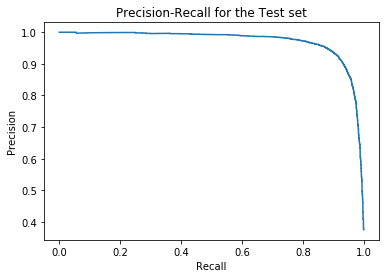

In [49]:
plt.figure()
plt.step(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall for the Test set');

## ROC

In [50]:
fpr, tpr, thresholds = roc_curve(y_true=[['Non-pA', 'pA'][i.item()] for i in interp.targs.argmax(axis=1)], 
                                 y_score=interp.preds[:,1], 
                                 pos_label='pA')
roc_auc = auc(fpr, tpr)

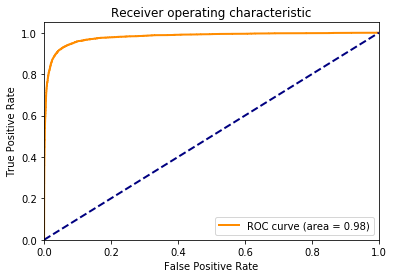

In [51]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## What's next?
1. Try other architectures, such as ResNet.
2. Interpret the model. 
3. Use the model for to find possible pA sites of inactive genes in the genome.